In [1]:
#basic package
import json
import tqdm
import os
import numpy as np
import glob
import pandas as pd
import sys
import shutil
import time
import datetime as dt
import itertools
import time
import re
from collections import Counter
from collections import defaultdict
import operator
import math
from scipy import stats
import pickle
from collections import Counter

#modelling
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

#plot
import matplotlib
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, acf, pacf

from matplotlib.collections import LineCollection
from matplotlib.colors import BoundaryNorm
import seaborn as sns

c:\users\camil\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
from UTILS import perc_element_dico
import config_mobility as config

c:\users\camil\anaconda3\lib\site-packages\_pytest\fixtures.py:844: DeprecationWarning: The `convert` argument is deprecated in favor of `converter`.  It will be removed after 2019/01.
  params = attr.ib(convert=attr.converters.optional(tuple))
c:\users\camil\anaconda3\lib\site-packages\_pytest\fixtures.py:846: DeprecationWarning: The `convert` argument is deprecated in favor of `converter`.  It will be removed after 2019/01.
  ids = attr.ib(default=None, convert=_ensure_immutable_ids)
c:\users\camil\anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


we restrict the time series to one value per 60 seconds 
we compute the complexity variables each 30 minutes 
each variables includes the values of at least the last 120.00 minutes (i.e. are using 120.00 values)


In [3]:
path_extracted_data = config.path_extracted_data
path_initial_data = config.path_initial_data
id_run = config.id_run
title_ = 'LB_mobility' #LSL_mobility, LB_mobility, all_mobility
path_save_ = os.path.join(path_extracted_data, 'visual', 'Daily_var_investigation', title_)
#create a director if not existinga
if not os.path.exists(path_save_):
    os.makedirs(path_save_)

# Data at KBF level

In [4]:
df_master = pd.read_csv(os.path.join(path_initial_data,'Mo_Masterfile.csv'), sep=';') #, parse_dates=['date']) wrong!
df_master['date'] = df_master['date'].map(lambda x: dt.datetime.strptime(x, "%d.%m.%Y"))
df_master.rename(columns={'time':'Timestamp','day':'DayID','hen':'HenID','date':'day'}, inplace=True)
#dico or join by hen (not day as some are nan but we actually know then)
df_master['HenID'] = df_master['HenID'].map(str)
dico_hen_group = dict(zip(df_master['HenID'].tolist(), df_master['group'].tolist()))
df_master['HenID'] = df_master['HenID'].map(lambda x: 'hen_'+str(x))
#df_master.filter(['HenID','group'])
#keep hybrid info
dico_henID_hybrid = dict(zip(df_master['HenID'].tolist(), df_master['hybrid'].tolist()))
print(df_master.shape)
df_master.head(3)

(7920, 43)


,HenID,timepoint,group,age,DayID,day,file,severity,pen,hybrid,...,meanchange,mean1,medianchange,transitions,real0,sumdur,nest_vs_total,severity_diff,KBF_new,indicator
0,hen_1,1,A,21,1,2016-10-27,1A01,0.0,1,LSL,...,1.23,1.0,1.0,91.0,NaN,57067.0,0.177419,NaN,0.0,NaN
1,hen_1,1,A,21,2,2016-10-28,1A01,0.0,1,LSL,...,1.28,1.0,1.0,108.0,NaN,56854.0,0.171053,0.0,0.0,NaN
2,hen_1,1,A,21,3,2016-10-29,1A01,0.0,1,LSL,...,1.17,1.0,1.0,128.0,NaN,56721.0,0.255319,0.0,0.0,NaN


In [5]:
#create dico to match each day to the session and number of days of the session
df_ = df_master.groupby('timepoint')['day'].agg(lambda x: sorted(set(x))).reset_index()
dico_day_sessiontpt = {}
for tpt in df_master['timepoint'].unique():
    li_d = df_[df_['timepoint']==tpt]['day'].values[0]
    for i,d in enumerate(li_d):
        dico_day_sessiontpt[d] = 'sess_'+str(tpt)+'_day'+str(i%6) #modulo 6 to take into account groups A and B
dico_day_sessiontpt

{Timestamp('2016-10-27 00:00:00'): 'sess_1_day0',
 Timestamp('2016-10-28 00:00:00'): 'sess_1_day1',
 Timestamp('2016-10-29 00:00:00'): 'sess_1_day2',
 Timestamp('2016-10-30 00:00:00'): 'sess_1_day3',
 Timestamp('2016-10-31 00:00:00'): 'sess_1_day4',
 Timestamp('2016-11-01 00:00:00'): 'sess_1_day5',
 Timestamp('2016-11-04 00:00:00'): 'sess_1_day0',
 Timestamp('2016-11-05 00:00:00'): 'sess_1_day1',
 Timestamp('2016-11-06 00:00:00'): 'sess_1_day2',
 Timestamp('2016-11-07 00:00:00'): 'sess_1_day3',
 Timestamp('2016-11-08 00:00:00'): 'sess_1_day4',
 Timestamp('2016-11-09 00:00:00'): 'sess_1_day5',
 Timestamp('2016-11-17 00:00:00'): 'sess_2_day0',
 Timestamp('2016-11-18 00:00:00'): 'sess_2_day1',
 Timestamp('2016-11-19 00:00:00'): 'sess_2_day2',
 Timestamp('2016-11-20 00:00:00'): 'sess_2_day3',
 Timestamp('2016-11-21 00:00:00'): 'sess_2_day4',
 Timestamp('2016-11-22 00:00:00'): 'sess_2_day5',
 Timestamp('2016-11-25 00:00:00'): 'sess_2_day0',
 Timestamp('2016-11-26 00:00:00'): 'sess_2_day1',


# MLPS at day level

In [6]:
li_path = glob.glob(os.path.join(path_extracted_data,'VF_time_serie_day_*_variables.csv'))
li_zone = ['zone_1', 'zone_2', 'zone_3', 'zone_4', 'zone_5']
li_df = []
for path_ in li_path:
    sessID = path_.split('_')[-3]
    df_ = pd.read_csv(path_, sep=';', index_col=0, parse_dates=['level','FirstTimestamp_zone_1','FirstTimestamp_zone_2',
                                                                'FirstTimestamp_zone_3','FirstTimestamp_zone_4',
                                                                'FirstTimestamp_zone_5'])
    #day 2017-08-07 egg quality must be linked to the MLPs variable of the day 2017-08-06 with possible bias induce by if the hen 
    #laid the egg at 9h on the 2017-08-06 (or anytime after 8h, the time where the people take the egg). 
    df_['egg_level'] = df_['level'].map(lambda x: x+dt.timedelta(days=1))
    if 'SampEnt_perZone' in df_.columns:
        for z in li_zone:
            df_['SampEnt_'+z] = df_['SampEnt_perZone'].map(lambda x: eval(x).get(z,0))
            df_['SampEnt_'+z] = df_['SampEnt_'+z].replace(-0.0,0)
    #df_.drop(columns=['verification_daily_total_duration'], inplace=True)    
    #put to have less change among the dependant variable entries
    #df_['SampEnt_order2'] = df_['SampEnt_order2'].map(lambda x: x*10000)
    ### from seconds to hours ###
    for v in ['max_duration','duration_zone_1','duration_zone_2','duration_zone_3','duration_zone_4','duration_zone_5']:
        df_[v] = df_[v].map(lambda x: x/60/60)
    df_['variance_duration'] = df_['variance_duration'].map(lambda x: x/(60*60)/(60*60))
    ### add hours ###
    li_fts = ['FirstTimestamp_zone_1','FirstTimestamp_zone_2','FirstTimestamp_zone_3','FirstTimestamp_zone_4',
              'FirstTimestamp_zone_5']
    for x in li_fts:
        df_[x+'_h'] = df_[x].map(lambda x: x.hour+x.minute/60+x.second/60/60)
        #lets say if we dont know that they went to 17h
        #df_[x+'_h'].fillna(17, inplace=True)
    df_['session'] = sessID
    li_df.append(df_)
df_mlp = pd.concat(li_df).reset_index()
df_mlp['hybrid'] = df_mlp['HenID'].apply(lambda x: dico_henID_hybrid[x])
print(df_mlp.shape)
df_mlp.head(3)

(7061, 63)


,HenID,FirstTimestamp_zone_1,FirstTimestamp_zone_1_h,FirstTimestamp_zone_2,FirstTimestamp_zone_2_h,FirstTimestamp_zone_3,FirstTimestamp_zone_3_h,FirstTimestamp_zone_4,FirstTimestamp_zone_4_h,FirstTimestamp_zone_5,...,percentile_85,percentile_95,session,t_DU_missingZone_mvtPerc,up_missingZone_mvtNbr,up_missingZone_mvtPerc,variance_duration,verification_daily_total_duration,zone_list,hybrid
0,hen_1,NaT,NaN,NaT,NaN,2017-07-06 09:09:28,9.157778,2017-07-06 02:18:44,2.312222,2017-07-06 02:00:00,...,75.785833,116.513333,day,"(3.7037037037037033, 0.0, 28)",0.0,0.000000,0.000120,54000.0,"('zone_5', 'zone_5', 'zone_5', 'zone_5', 'zone...",LSL
1,hen_1,NaT,NaN,2017-07-07 10:56:30,10.941667,2017-07-07 10:46:28,10.774444,2017-07-07 04:34:12,4.570000,2017-07-07 02:00:00,...,61.266667,97.116667,day,"(0.0, 0.0, 41)",0.0,0.000000,0.000096,54000.0,"('zone_5', 'zone_5', 'zone_5', 'zone_5', 'zone...",LSL
2,hen_1,NaT,NaN,NaT,NaN,2017-07-08 05:28:13,5.470278,2017-07-08 05:19:38,5.327222,2017-07-08 02:00:00,...,65.097500,73.026667,day,"(0.0, 3.0303030303030303, 34)",1.0,3.030303,0.000113,54000.0,"('zone_5', 'zone_5', 'zone_5', 'zone_5', 'zone...",LSL


In [7]:
df_mlp[['variance_duration','max_duration','duration_zone_1','duration_zone_5','verification_daily_total_duration']]

,variance_duration,max_duration,duration_zone_1,duration_zone_5,verification_daily_total_duration
0,0.000120,0.039731,0.000000,11.987500,54000.0
1,0.000096,0.042833,0.000000,12.091944,54000.0
2,0.000113,0.055454,0.000000,11.883333,54000.0
3,0.000081,0.038245,0.000000,11.902500,54000.0
4,0.000113,0.060421,0.000000,11.131389,54000.0
5,0.000086,0.034648,0.000000,11.389444,54000.0
6,0.000226,0.086417,0.000000,11.215556,54000.0
7,0.000270,0.065634,0.000000,12.834167,54000.0
8,0.000103,0.035042,0.000000,10.741389,54000.0
9,0.000134,0.050264,0.000000,8.445000,54000.0


In [10]:
df_mlp.columns

Index(['HenID', 'FirstTimestamp_zone_1', 'FirstTimestamp_zone_1_h',
       'FirstTimestamp_zone_2', 'FirstTimestamp_zone_2_h',
       'FirstTimestamp_zone_3', 'FirstTimestamp_zone_3_h',
       'FirstTimestamp_zone_4', 'FirstTimestamp_zone_4_h',
       'FirstTimestamp_zone_5', 'FirstTimestamp_zone_5_h',
       'Max_duration_zone_4', 'Max_duration_zones', 'SampEnt_order2',
       'Total_number_transition', 'Total_number_zone',
       'chatoicmvt_Middlezone_1', 'chatoicmvt_Middlezone_1_nbr',
       'chatoicmvt_Middlezone_2', 'chatoicmvt_Middlezone_2_nbr',
       'chatoicmvt_Middlezone_3', 'chatoicmvt_Middlezone_3_nbr',
       'chatoicmvt_Middlezone_4', 'chatoicmvt_Middlezone_4_nbr',
       'chatoicmvt_Middlezone_5', 'chatoicmvt_Middlezone_5_nbr',
       'dico_z_chaoticmvtMiddleDuration', 'dico_zone_sortedduration',
       'distribution_entropy', 'down_missingZone_mvtNbr',
       'down_missingZone_mvtPerc', 'dur_values', 'dur_values_normalized',
       'duration_zone_1', 'duration_zone_2',

In [11]:
#keep columns of one species only if wanted
print(df_mlp.shape)
if title_ =='LB_mobility':
    df_mlp = df_mlp[df_mlp['hybrid']=='LB']
if title_ =='LSL_mobility':
    df_mlp = df_mlp[df_mlp['hybrid']=='LSL']
print(df_mlp.shape)

(7061, 63)
(3545, 63)


In [12]:
#fill nan
li = ['SampEnt_order2', 'distribution_entropy']
df_mlp[li] = df_mlp[li].fillna(0.0)

In [13]:
#save
df_mlp.to_csv(os.path.join(path_save_,'df_mlp.csv'), index=False, sep=';')

In [14]:
#print rows with at least 10 nan values
df_mlp[df_mlp.isnull().sum(axis=1)>1]

,HenID,FirstTimestamp_zone_1,FirstTimestamp_zone_1_h,FirstTimestamp_zone_2,FirstTimestamp_zone_2_h,FirstTimestamp_zone_3,FirstTimestamp_zone_3_h,FirstTimestamp_zone_4,FirstTimestamp_zone_4_h,FirstTimestamp_zone_5,...,percentile_85,percentile_95,session,t_DU_missingZone_mvtPerc,up_missingZone_mvtNbr,up_missingZone_mvtPerc,variance_duration,verification_daily_total_duration,zone_list,hybrid
182,hen_41,NaT,NaN,2017-07-08 10:36:20,10.605556,2017-07-08 02:00:00,2.000000,2017-07-08 02:59:54,2.998333,2017-07-08 03:48:28,...,50.223333,81.794167,day,"(2.3255813953488373, 0.0, 44)",0.0,0.000000,0.000063,54000.0,"('zone_3', 'zone_3', 'zone_3', 'zone_3', 'zone...",LB
199,hen_44,NaT,NaN,2017-07-07 02:09:06,2.151667,2017-07-07 02:00:00,2.000000,2017-07-07 06:31:09,6.519167,2017-07-07 07:12:02,...,91.004167,184.483333,day,"(0.0, 0.0, 16)",0.0,0.000000,0.000725,54000.0,"('zone_3', 'zone_3', 'zone_3', 'zone_3', 'zone...",LB
208,hen_45,NaT,NaN,NaT,NaN,2017-07-10 08:49:50,8.830556,2017-07-10 05:08:42,5.145000,2017-07-10 02:00:00,...,48.525000,183.391667,day,"(0.0, 0.0, 31)",0.0,0.000000,0.000264,54000.0,"('zone_5', 'zone_5', 'zone_5', 'zone_5', 'zone...",LB
212,hen_46,NaT,NaN,NaT,NaN,NaT,NaN,2017-07-08 04:43:54,4.731667,2017-07-08 02:00:00,...,538.225000,645.175000,day,"(0.0, 0.0, 3)",0.0,0.000000,0.006337,54000.0,"('zone_5', 'zone_5', 'zone_5', 'zone_5', 'zone...",LB
214,hen_46,NaT,NaN,NaT,NaN,NaT,NaN,2017-07-10 04:20:02,4.333889,2017-07-10 02:00:00,...,540.048333,654.338333,day,"(0.0, 0.0, 3)",0.0,0.000000,0.006640,54000.0,"('zone_5', 'zone_5', 'zone_5', 'zone_5', 'zone...",LB
215,hen_46,NaT,NaN,2017-07-11 11:02:45,11.045833,2017-07-11 10:58:48,10.980000,2017-07-11 04:20:22,4.339444,2017-07-11 02:00:00,...,295.553333,367.750000,day,"(0.0, 0.0, 9)",0.0,0.000000,0.001663,54000.0,"('zone_5', 'zone_5', 'zone_5', 'zone_5', 'zone...",LB
232,hen_51,NaT,NaN,NaT,NaN,2017-07-10 03:53:41,3.894722,2017-07-10 02:16:19,2.271944,2017-07-10 02:00:00,...,304.553333,511.740000,day,"(0.0, 0.0, 5)",0.0,0.000000,0.003721,54000.0,"('zone_5', 'zone_5', 'zone_5', 'zone_5', 'zone...",LB
233,hen_51,NaT,NaN,NaT,NaN,2017-07-11 11:12:58,11.216111,2017-07-11 05:13:57,5.232500,2017-07-11 02:00:00,...,47.750000,262.966667,day,"(0.0, 0.0, 21)",0.0,0.000000,0.000592,54000.0,"('zone_5', 'zone_5', 'zone_5', 'zone_5', 'zone...",LB
234,hen_53,NaT,NaN,2017-07-06 05:09:01,5.150278,2017-07-06 05:12:29,5.208056,2017-07-06 05:13:21,5.222500,2017-07-06 02:00:00,...,142.675000,356.625000,day,"(10.0, 0.0, 11)",0.0,0.000000,0.001747,54000.0,"('zone_5', 'zone_5', 'zone_5', 'zone_5', 'zone...",LB
235,hen_53,NaT,NaN,2017-07-07 04:59:50,4.997222,2017-07-07 05:03:37,5.060278,2017-07-07 05:03:50,5.063889,2017-07-07 02:00:00,...,366.946667,554.060000,day,"(25.0, 0.0, 5)",0.0,0.000000,0.004544,54000.0,"('zone_5', 'zone_5', 'zone_5', 'zone_5', 'zone...",LB


In [15]:
#df_mlp[['nbr_bouts_zone_1','duration_zone_1','FirstTimestamp_zone_1', 'FirstTimestamp_zone_1_h']]

## Hen level dataframe and plot

#### outside

True     2869
False     676
Name: went_outside, dtype: int64

(60, 2)


,HenID,perc_days_outside
0,hen_100,74.468085
1,hen_101,33.846154
2,hen_102,87.500000


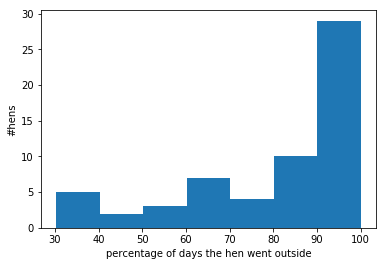

In [16]:
#some hens goes outside, some not!
#add outside variables
df_mlp['went_outside'] = df_mlp['nbr_bouts_zone_1'].map(lambda x: x>0)
display(df_mlp['went_outside'].value_counts())
df_outside = df_mlp.groupby(['HenID'])['went_outside'].agg(lambda x: sum(x)/len(x)*100).reset_index()
df_outside.rename(columns={'went_outside':'perc_days_outside'}, inplace=True)
print(df_outside.shape)
display(df_outside.head(3))
#histogram
plt.hist(df_outside['perc_days_outside'].dropna(),bins='auto') #bins=15: into 15 equal parts 
plt.xlabel('percentage of days the hen went outside')
plt.ylabel('#hens');
plt.savefig(os.path.join(path_save_,'histogram of percentage of days hens went outside.png'),
            pi=300,format='png',bbox_inches='tight')
plt.show()

,HenID,percentage over last 15 recorded days of going outside
0,hen_100,"[60.0, 66.66666666666666, 73.33333333333333, 8..."
1,hen_101,"[93.33333333333333, 86.66666666666667, 86.6666..."
2,hen_102,"[86.66666666666667, 86.66666666666667, 93.3333..."
3,hen_103,"[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100..."
4,hen_104,"[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100..."


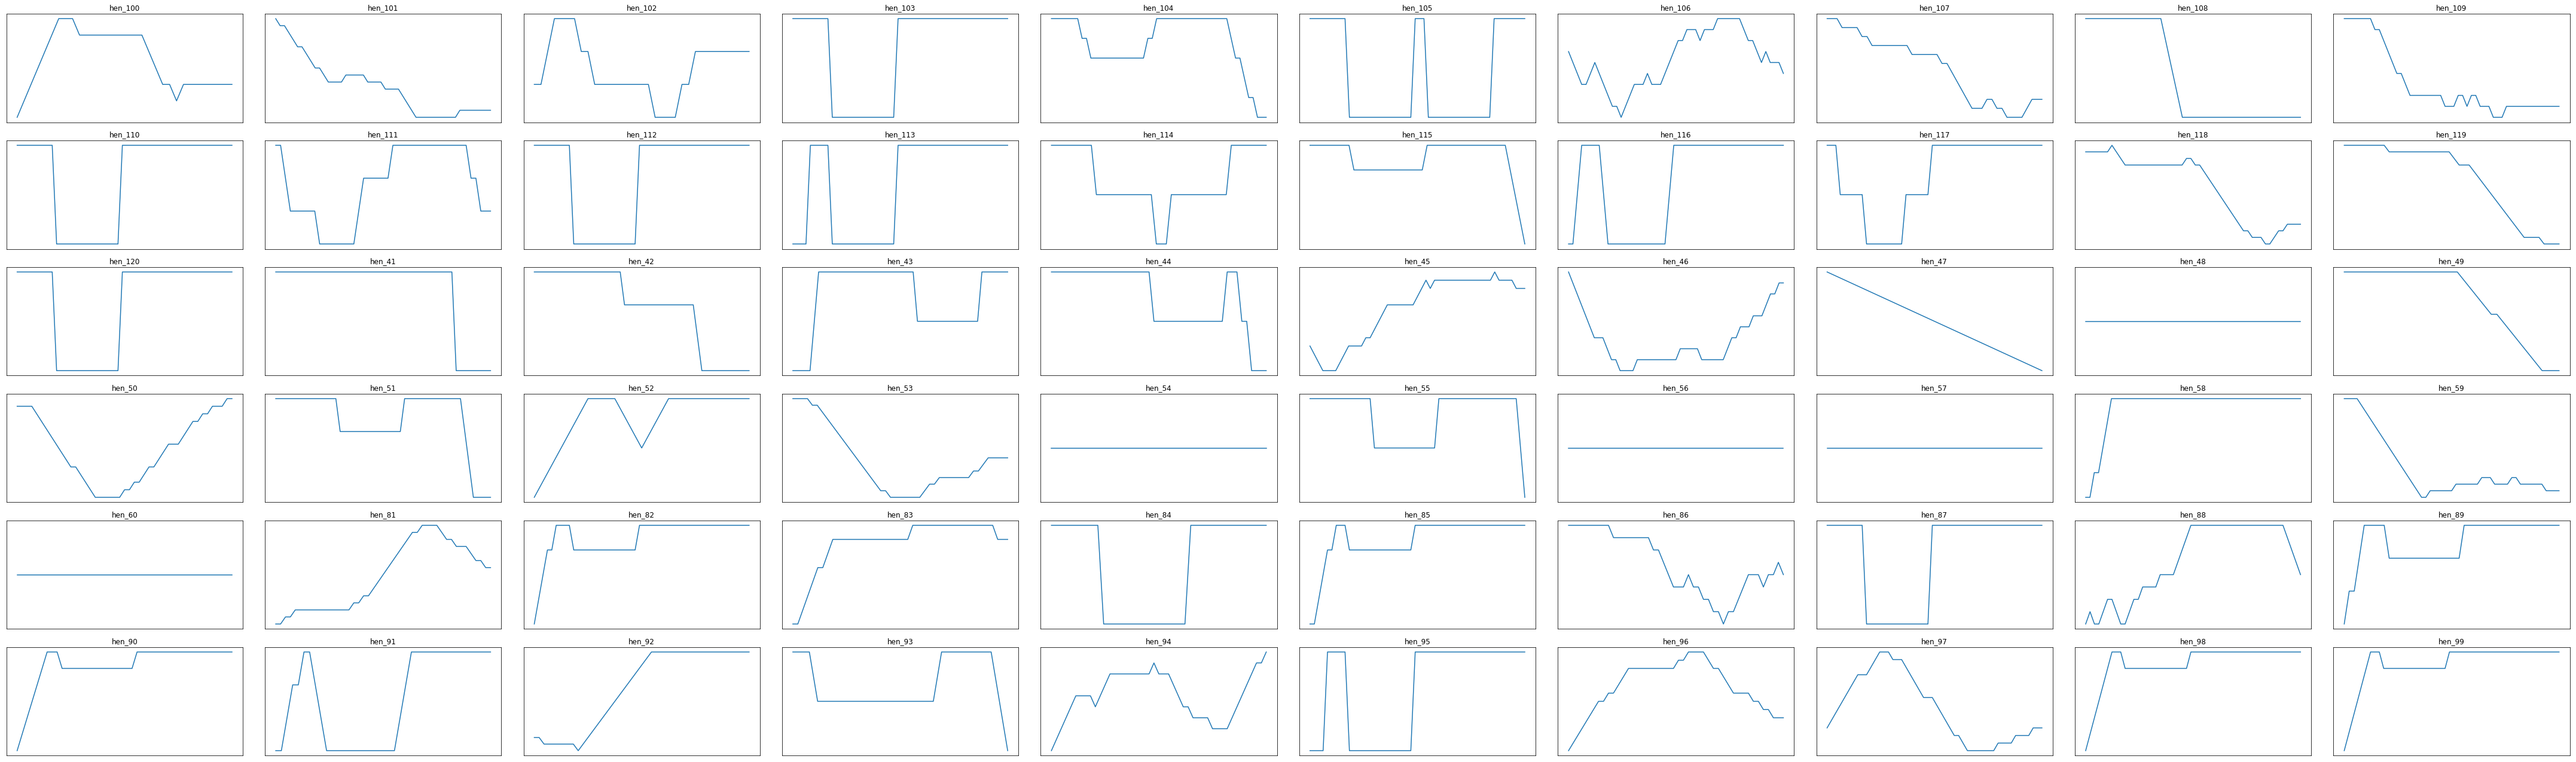

In [17]:
#but, does it depend on time of the year too? Lets plot the percentage of went outside over the last 7 days
df_mlp = df_mlp.sort_values(['HenID','level'],ascending=True)
#df_mlp[['HenID','level']]
d = 15
df_plot = df_mlp.groupby(['HenID'])['went_outside'].agg(lambda x: [sum(list(x)[i-d:i])/d*100 for i in range(d, len(list(x)))]).reset_index()
#small verification
#l = [True, False, False, False, False,True, False,True, False,True, False,True, False,True, False,True, False]
#d = 5
#[sum(l[i-d:i])/d*100 for i in range(d, len(l))]
df_plot.rename(columns={'went_outside':'percentage over last %d recorded days of going outside'%d}, inplace=True)
display(df_plot.head(5))
c = 10
l = math.ceil(df_plot.shape[0]/c) #round up
img_w = 6 
img_h = 3 
fig = plt.figure(figsize=(int(c*img_w), int(l*img_h)))
for i in range(df_plot.shape[0]):
    plt.subplot(l,c,i+1)
    plt.tight_layout()
    plt.plot(df_plot['percentage over last %d recorded days of going outside'%d].tolist()[i]);
    plt.xticks([]) #remove xlabel annotations
    plt.yticks([])
    henid = df_plot['HenID'].tolist()[i]
    plt.title(henid,size=12)
plt.savefig(os.path.join(path_save_,'rolling %d days windowed of percentage of days going outside.png'%d),
            pi=300,format='png',bbox_inches='tight')
plt.show()

#### add chaotic mvt

In [18]:
#add avg of chaotic mvt across all days
df_hen = df_mlp.groupby(['HenID'])[['chatoicmvt_Middlezone_1_nbr', 'chatoicmvt_Middlezone_2_nbr',
                       'chatoicmvt_Middlezone_3_nbr', 'chatoicmvt_Middlezone_4_nbr',
                       'chatoicmvt_Middlezone_5_nbr']].agg(lambda x: np.mean(x)).reset_index()
df_hen = pd.merge(df_hen, df_outside, on=['HenID'])
print(df_hen.shape)
df_hen.head(3)

(60, 7)


,HenID,chatoicmvt_Middlezone_1_nbr,chatoicmvt_Middlezone_2_nbr,chatoicmvt_Middlezone_3_nbr,chatoicmvt_Middlezone_4_nbr,chatoicmvt_Middlezone_5_nbr,perc_days_outside
0,hen_100,0.787234,5.191489,4.702128,0.276596,0.127660,74.468085
1,hen_101,0.015385,0.307692,0.246154,0.507692,0.292308,33.846154
2,hen_102,0.083333,5.270833,3.583333,0.145833,0.000000,87.500000


In [19]:
#df_hen[df_hen['HenID'].isin(['hen_19', 'hen_81'])] #with all_mobility

,HenID,chatoicmvt_Middlezone_1_nbr,chatoicmvt_Middlezone_2_nbr,chatoicmvt_Middlezone_3_nbr,chatoicmvt_Middlezone_4_nbr,chatoicmvt_Middlezone_5_nbr,perc_days_outside
41,hen_81,0.133333,7.116667,7.333333,0.15,0.0,38.333333


#### save

In [20]:
df_hen.to_csv(os.path.join(path_save_,'df_hen.csv'), index=False, sep=';')